Of course. SARIMA is an extension of ARIMA designed specifically to handle seasonal data. The key difference is that **SARIMA adds a set of seasonal parameters** to the standard ARIMA model.

Let's break it down:

  * **ARIMA(p, d, q)**: This model combines **A**uto**R**egression (AR), **I**ntegrated (I), and **M**oving **A**verage (MA) components to model the trend and relationships between consecutive data points.

      * **p**: The number of lag observations included in the model (AR part).
      * **d**: The number of times the raw observations are differenced (I part).
      * **q**: The size of the moving average window (MA part).

  * **SARIMA(p, d, q)(P, D, Q)m**: This model, also known as Seasonal ARIMA, includes the same three parameters plus an additional set for seasonality.

      * **(p, d, q)**: The non-seasonal parameters, just like in ARIMA.
      * **(P, D, Q)**: The **seasonal** parameters, which work similarly to their non-seasonal counterparts but operate on data points separated by the seasonal period.
      * **m**: The number of time steps in a single seasonal period (e.g., 12 for monthly data with yearly seasonality).

In essence, a SARIMA model is like running two ARIMA processes simultaneously: one for the non-seasonal trend and another for the seasonal component.

-----

## Python Example: ARIMA vs. SARIMA

Here's a Python example that clearly shows where ARIMA falls short and SARIMA excels when dealing with seasonal data. We'll use the `statsmodels` library.

First, let's create a synthetic dataset that has both a clear upward trend and a strong yearly seasonality.


c:\Users\schre\anaconda3\envs\dev\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\schre\AppData\Local\Temp\ipykernel_26292\4106468183.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range(start='2015-01-01', periods=n_samples, freq='M')


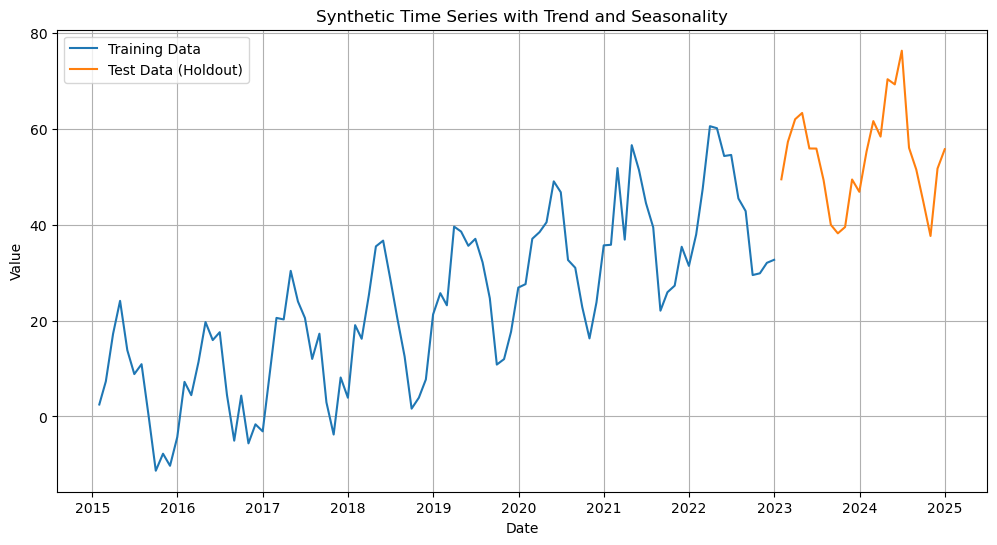

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

# 1. Generate Synthetic Seasonal Data
np.random.seed(42)
n_samples = 120 # 10 years of monthly data
time = np.arange(n_samples)

# Create a trend, seasonality, and noise
trend = 0.5 * time
seasonality = 15 * np.sin(2 * np.pi * time / 12) # Yearly seasonality (12 months)
noise = np.random.normal(0, 5, n_samples)

# Combine them to create the time series
data = trend + seasonality + noise

# Create a pandas Series with a DatetimeIndex
index = pd.date_range(start='2015-01-01', periods=n_samples, freq='M')
ts_data = pd.Series(data, index=index)

# Split data into training and testing sets
train_data = ts_data[:-24] # Use 8 years for training
test_data = ts_data[-24:]  # Hold out the last 2 years for testing

# Plot the data to see the pattern
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data (Holdout)')
plt.title('Synthetic Time Series with Trend and Seasonality')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


The plot clearly shows a repeating pattern every year and a general upward slope. This is the kind of data SARIMA is built for.

### ARIMA Model Attempt

Now, let's try to fit a standard ARIMA model. We'll use the parameters $(p, d, q) = (1, 1, 1)$, which are common starting points.


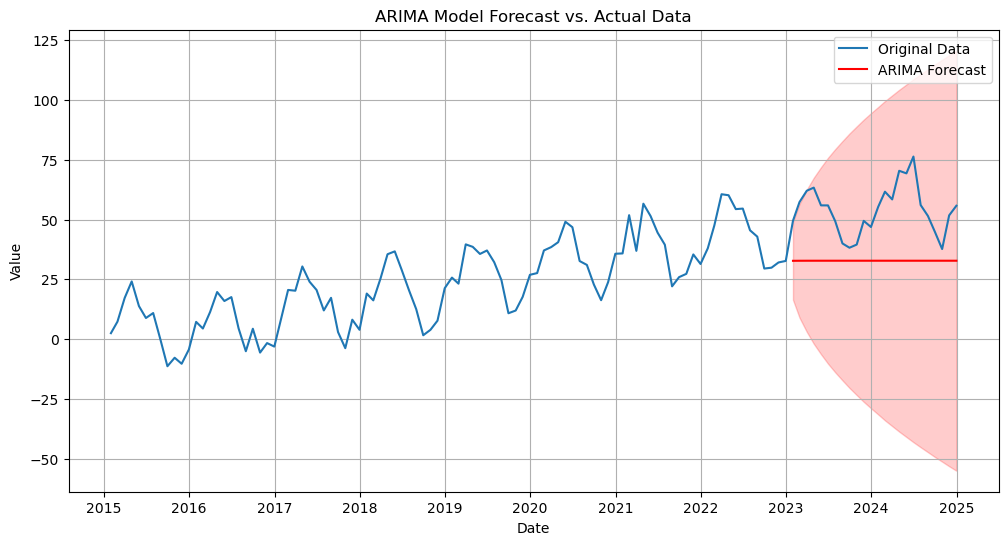

In [2]:
# 2. Fit a standard ARIMA model
# We use order (p=1, d=1, q=1)
arima_model = ARIMA(train_data, order=(1, 1, 1))
arima_result = arima_model.fit()

# Forecast for the next 24 months (the test period)
arima_forecast = arima_result.get_forecast(steps=24)
arima_pred = arima_forecast.predicted_mean
arima_ci = arima_forecast.conf_int()

# Plot the ARIMA forecast against the actual data
plt.figure(figsize=(12, 6))
plt.plot(ts_data, label='Original Data')
plt.plot(arima_pred, label='ARIMA Forecast', color='red')
plt.fill_between(arima_ci.index,
                 arima_ci.iloc[:, 0],
                 arima_ci.iloc[:, 1], color='red', alpha=0.2)
plt.title('ARIMA Model Forecast vs. Actual Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


As you can see, the **ARIMA model captures the overall trend but completely misses the seasonal fluctuations**. The forecast is just a smooth line, which is not useful for predicting the seasonal peaks and troughs.

### SARIMA Model Solution

Now, let's use a SARIMA model. We'll add the seasonal parameters $(P, D, Q, m)$. We'll use $(1, 1, 1)$ for the seasonal order and set $m=12$ since our data has a yearly pattern. The full model is $SARIMA(1, 1, 1)(1, 1, 1)\_{12}$.



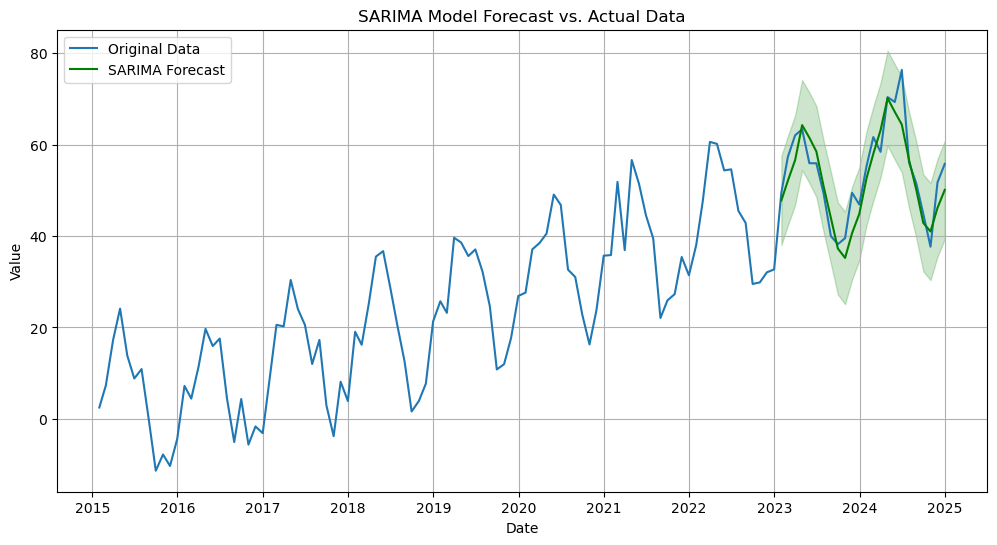

In [3]:
# 3. Fit a SARIMA model
# Non-seasonal order (p,d,q) = (1,1,1)
# Seasonal order (P,D,Q,m) = (1,1,1,12)
sarima_model = SARIMAX(train_data,
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit(disp=False) # disp=False to hide convergence messages

# Forecast for the next 24 months
sarima_forecast = sarima_result.get_forecast(steps=24)
sarima_pred = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

# Plot the SARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(ts_data, label='Original Data')
plt.plot(sarima_pred, label='SARIMA Forecast', color='green')
plt.fill_between(sarima_ci.index,
                 sarima_ci.iloc[:, 0],
                 sarima_ci.iloc[:, 1], color='green', alpha=0.2)
plt.title('SARIMA Model Forecast vs. Actual Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


Success\! 📈 The **SARIMA model's forecast beautifully captures both the trend and the seasonal cycles**, aligning closely with the actual holdout data.

-----

## Pros and Cons

### ARIMA

| Pros 👍                                                                | Cons 👎                                                                  |
| :--------------------------------------------------------------------- | :----------------------------------------------------------------------- |
| **Simpler**: Fewer parameters ($p, d, q$) make it easier to configure.    | **Seasonally Unaware**: Fails to model seasonal patterns, leading to poor forecasts on such data. |
| **Good for Non-Seasonal Data**: Excellent for time series with only a trend and/or cycles that are not on a fixed, regular schedule. | **Less Flexible**: Cannot handle the complex interactions between trend and seasonality. |
| **Faster Computation**: Generally quicker to train due to its simplicity. | **Requires Stationary Data**: The data must be made stationary through differencing ($d$). |

### SARIMA

| Pros 👍                                                                | Cons 👎                                                                  |
| :--------------------------------------------------------------------- | :----------------------------------------------------------------------- |
| **Excellent for Seasonal Data**: Explicitly models seasonal components, resulting in highly accurate forecasts. | **More Complex**: Requires tuning seven parameters ($p, d, q, P, D, Q, m$), which can be challenging. |
| **Highly Flexible**: Can model a wide variety of seasonal time series by combining trend and seasonal components. | **Computationally Intensive**: Can be slower to train, especially with long seasonal periods. |
| **Comprehensive**: Captures trend, seasonality, and residual dynamics in a single model. | **Requires Regular Seasonality**: Assumes the seasonal pattern is consistent over time. |

In summary, the choice is straightforward: **if your data has a repeating, fixed-period pattern (seasonality), use SARIMA.** If it does not, a standard ARIMA model is more appropriate.